## Convolutional Neural Network for MNIST image classficiation 

In [2]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.gridspec as gridspec

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Alternating Least Squares for Matrix Factorization

In [3]:
def coding_within_radius(X, W, H0, 
                         r=None, 
                         a1=0, #L1 regularizer
                         a2=0, #L2 regularizer
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + a1 * np.ones(len(idx))) + a2 * 2 * np.sign(H1[k,idx])
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size
            if np.linalg.norm(H1_old, 2) == 0:
                two_norm = 10**-6
            else:
                two_norm = np.linalg.norm(H1_old, 2)
            if step_size * grad_norm / two_norm > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

In [4]:
def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

In [4]:
# Simulated Data and its factorization 

W0 = np.random.rand(10,5)
H0 = np.random.rand(5,20)
X0 = W0 @ H0

W, H = ALS(X=X0, 
           n_components=5, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

print('reconstruction error (relative) = %f' % (np.linalg.norm(X0-W@H)**2/np.linalg.norm(X0)**2))
print('Dictionary error (relative) = %f' % (np.linalg.norm(W0 - W)**2/np.linalg.norm(W0)**2))
print('Code error (relative) = %f' % (np.linalg.norm(H0-H)**2/np.linalg.norm(H0)**2))


 31%|████████████████████████▊                                                       | 31/100 [00:00<00:00, 156.85it/s]

iteration 0, reconstruction error 9.883176
iteration 10, reconstruction error 1.786173
iteration 20, reconstruction error 1.010678
iteration 30, reconstruction error 0.857318


 67%|█████████████████████████████████████████████████████▌                          | 67/100 [00:00<00:00, 170.03it/s]

iteration 40, reconstruction error 0.793472
iteration 50, reconstruction error 0.761026
iteration 60, reconstruction error 0.728583
iteration 70, reconstruction error 0.696786


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 164.76it/s]

iteration 80, reconstruction error 0.665601
iteration 90, reconstruction error 0.625693
reconstruction error (relative) = 0.001931
Dictionary error (relative) = 0.801182
Code error (relative) = 21.716178


# Learn dictionary of MNIST images 

In [5]:
def display_dictionary(W,label,rows,cols,save_name=None):
    k = int(np.sqrt(W.shape[0]))
#     rows = int(np.sqrt(W.shape[1]))
#     cols = int(np.sqrt(W.shape[1]))
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 2, rows * 2),
                            subplot_kw={'xticks': [], 'yticks': []})
    for ax, i in zip(axs.flat, range(100)):
#         print(i)
#         a = i % (rows) #sub-lattice indices
#         b = i // (cols)
#         print(a,b)
        ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
#         if (b>0):
#             ax.set_yticks([])
#         if (b < cols-1):
#             ax.set_xticks([])
    
    plt.tight_layout()
    plt.suptitle(label, fontsize=16)
#     plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [6]:
def display_dictionary_list(W_list, label_list,sub_rows,sub_cols,save_name=None):
    # Make plot
    
    # outer gridspec
    nrows=1
#     ncols=3
    ncols=1
    fig = plt.figure(figsize=(3, 4), constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.05)

    # make nested gridspecs
    for i in range(1 * ncols):
        k = int(np.sqrt(W_list[i].shape[0]))

        inner_grid = outer_grid[i].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

        for j in range(sub_rows*sub_cols):
            a = j % (sub_cols) #sub-lattice indices
            b = j // (sub_rows) 
#             print('ab',a,b)
            ax = fig.add_subplot(inner_grid[a, b])
            ax.imshow(W_list[i].T[j].reshape(k, k), cmap="viridis", interpolation='nearest')
            if (b>0):
                ax.set_yticks([])
            if (a < sub_rows-1):
                ax.set_xticks([])
            if (a == 0) and (b==2):
                #ax.set_title("W_nonnegativity$=$ %s \n H_nonnegativity$=$ %s" 
                #             % (str(nonnegativity_list[i][0]), str(nonnegativity_list[i][1])), y=1.2, fontsize=14) 
                ax.set_title(label_list[i], y=1.2, fontsize=14)
    
    return ax
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
#     plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
#     plt.savefig(save_name, bbox_inches='tight')

In [7]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

  2%|█▋                                                                                 | 1/50 [00:00<00:17,  2.84it/s]

iteration 0, reconstruction error 6544.326892


 22%|██████████████████                                                                | 11/50 [00:03<00:12,  3.13it/s]

iteration 10, reconstruction error 1962.626106


 42%|██████████████████████████████████▍                                               | 21/50 [00:06<00:08,  3.37it/s]

iteration 20, reconstruction error 1583.067057


 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:09<00:05,  3.27it/s]

iteration 30, reconstruction error 1429.002353


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:12<00:02,  3.35it/s]

iteration 40, reconstruction error 1349.132215


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


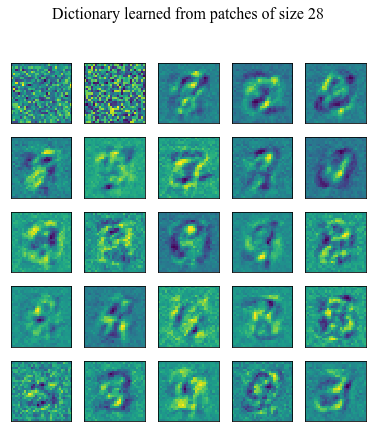

In [20]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X.iloc[idx,:].T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           W_nonnegativity=False,
           H_nonnegativity=False,
           compute_recons_error=True)

display_dictionary(W)

  3%|▎         | 3/100 [00:00<00:11,  8.79it/s]

iteration 0, reconstruction error 6372.128254


 12%|█▏        | 12/100 [00:01<00:07, 11.36it/s]

iteration 10, reconstruction error 1861.407487


 22%|██▏       | 22/100 [00:01<00:07, 10.68it/s]

iteration 20, reconstruction error 1447.760624


 32%|███▏      | 32/100 [00:02<00:05, 11.59it/s]

iteration 30, reconstruction error 1303.521291


 42%|████▏     | 42/100 [00:03<00:05, 10.88it/s]

iteration 40, reconstruction error 1226.971731


 52%|█████▏    | 52/100 [00:04<00:04, 11.14it/s]

iteration 50, reconstruction error 1177.775397


 62%|██████▏   | 62/100 [00:05<00:02, 13.04it/s]

iteration 60, reconstruction error 1142.187410


 72%|███████▏  | 72/100 [00:07<00:04,  6.64it/s]

iteration 70, reconstruction error 1114.740601


 82%|████████▏ | 82/100 [00:08<00:03,  5.84it/s]

iteration 80, reconstruction error 1093.794113


 92%|█████████▏| 92/100 [00:10<00:01,  5.78it/s]

iteration 90, reconstruction error 1078.081854


  2%|▏         | 2/100 [00:00<00:17,  5.55it/s]

iteration 0, reconstruction error 4760.721241


 12%|█▏        | 12/100 [00:02<00:15,  5.53it/s]

iteration 10, reconstruction error 1406.626979


 22%|██▏       | 22/100 [00:03<00:09,  8.47it/s]

iteration 20, reconstruction error 1016.498930


 32%|███▏      | 32/100 [00:04<00:06, 10.64it/s]

iteration 30, reconstruction error 936.043287


 42%|████▏     | 42/100 [00:05<00:04, 11.70it/s]

iteration 40, reconstruction error 901.302925


 52%|█████▏    | 52/100 [00:05<00:03, 12.48it/s]

iteration 50, reconstruction error 887.407258


 62%|██████▏   | 62/100 [00:06<00:02, 12.76it/s]

iteration 60, reconstruction error 882.073719


 72%|███████▏  | 72/100 [00:07<00:02,  9.73it/s]

iteration 70, reconstruction error 879.843463


 82%|████████▏ | 82/100 [00:08<00:02,  7.79it/s]

iteration 80, reconstruction error 878.801996


 92%|█████████▏| 92/100 [00:09<00:00,  9.85it/s]

iteration 90, reconstruction error 878.261936


  2%|▏         | 2/100 [00:00<00:07, 13.35it/s]

iteration 0, reconstruction error 4836.447610


 12%|█▏        | 12/100 [00:01<00:07, 11.62it/s]

iteration 10, reconstruction error 2125.683435


 22%|██▏       | 22/100 [00:01<00:06, 11.45it/s]

iteration 20, reconstruction error 1881.485890


 32%|███▏      | 32/100 [00:02<00:06, 10.34it/s]

iteration 30, reconstruction error 1770.024288


 42%|████▏     | 42/100 [00:03<00:05, 10.95it/s]

iteration 40, reconstruction error 1681.872795


 52%|█████▏    | 52/100 [00:04<00:04, 10.12it/s]

iteration 50, reconstruction error 1528.799010


 62%|██████▏   | 62/100 [00:05<00:03, 10.15it/s]

iteration 60, reconstruction error 1500.103029


 72%|███████▏  | 72/100 [00:06<00:02, 10.20it/s]

iteration 70, reconstruction error 1494.516004


 82%|████████▏ | 82/100 [00:07<00:01,  9.50it/s]

iteration 80, reconstruction error 1492.324771


 92%|█████████▏| 92/100 [00:08<00:00,  9.57it/s]

iteration 90, reconstruction error 1490.982548


100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


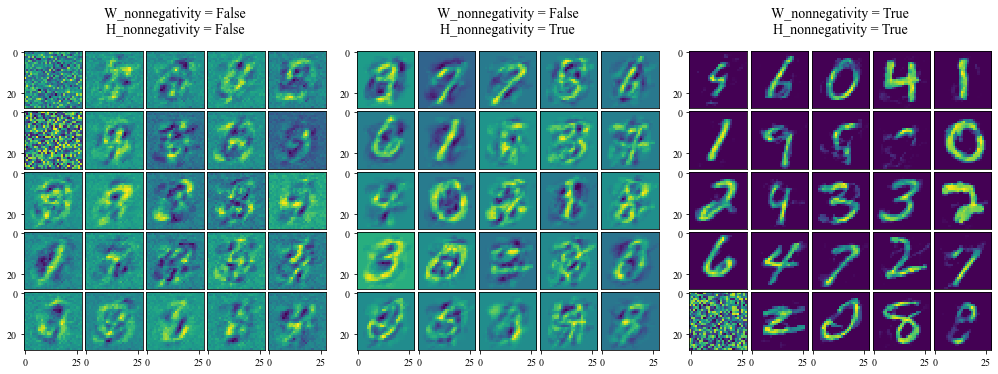

In [11]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    


label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex1.pdf")



In [8]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [34]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X.iloc[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01.iloc[i,:].values.reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

  2%|█▋                                                                                | 2/100 [00:00<00:22,  4.28it/s]

iteration 0, reconstruction error 12735.873735


 12%|█████████▋                                                                       | 12/100 [00:02<00:17,  4.96it/s]

iteration 10, reconstruction error 4283.118050


 21%|█████████████████                                                                | 21/100 [00:04<00:16,  4.91it/s]

iteration 20, reconstruction error 3622.557110


 32%|█████████████████████████▉                                                       | 32/100 [00:06<00:13,  4.99it/s]

iteration 30, reconstruction error 3314.183776


 41%|█████████████████████████████████▏                                               | 41/100 [00:08<00:11,  5.01it/s]

iteration 40, reconstruction error 3122.803468


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:10<00:10,  4.87it/s]

iteration 50, reconstruction error 3006.224673


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:12<00:07,  4.92it/s]

iteration 60, reconstruction error 2926.788035


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:14<00:05,  4.93it/s]

iteration 70, reconstruction error 2866.918118


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:16<00:03,  5.07it/s]

iteration 80, reconstruction error 2819.790721


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:18<00:01,  4.92it/s]

iteration 90, reconstruction error 2783.069335


  1%|▊                                                                                 | 1/100 [00:00<00:21,  4.66it/s]

iteration 0, reconstruction error 7627.704565


 12%|█████████▋                                                                       | 12/100 [00:02<00:17,  4.97it/s]

iteration 10, reconstruction error 4448.762094


 21%|█████████████████                                                                | 21/100 [00:04<00:16,  4.76it/s]

iteration 20, reconstruction error 3339.479008


 32%|█████████████████████████▉                                                       | 32/100 [00:06<00:14,  4.82it/s]

iteration 30, reconstruction error 2714.888678


 42%|██████████████████████████████████                                               | 42/100 [00:08<00:11,  4.84it/s]

iteration 40, reconstruction error 2540.115568


 52%|██████████████████████████████████████████                                       | 52/100 [00:10<00:10,  4.73it/s]

iteration 50, reconstruction error 2476.544132


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:12<00:08,  4.81it/s]

iteration 60, reconstruction error 2441.011761


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:14<00:05,  4.78it/s]

iteration 70, reconstruction error 2417.932127


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:17<00:03,  4.78it/s]

iteration 80, reconstruction error 2401.341724


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:18<00:01,  4.77it/s]

iteration 90, reconstruction error 2388.788686


  1%|▊                                                                                 | 1/100 [00:00<00:20,  4.73it/s]

iteration 0, reconstruction error 7710.566571


 12%|█████████▋                                                                       | 12/100 [00:02<00:18,  4.79it/s]

iteration 10, reconstruction error 4656.963933


 22%|█████████████████▊                                                               | 22/100 [00:04<00:16,  4.79it/s]

iteration 20, reconstruction error 4250.953623


 32%|█████████████████████████▉                                                       | 32/100 [00:06<00:14,  4.82it/s]

iteration 30, reconstruction error 3910.963830


 41%|█████████████████████████████████▏                                               | 41/100 [00:08<00:13,  4.31it/s]

iteration 40, reconstruction error 3792.419725


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:10<00:10,  4.74it/s]

iteration 50, reconstruction error 3662.601333


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:13<00:08,  4.83it/s]

iteration 60, reconstruction error 3560.031699


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:15<00:05,  4.94it/s]

iteration 70, reconstruction error 3481.640168


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:17<00:03,  4.97it/s]

iteration 80, reconstruction error 3427.557029


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:19<00:01,  4.79it/s]

iteration 90, reconstruction error 3410.679033


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


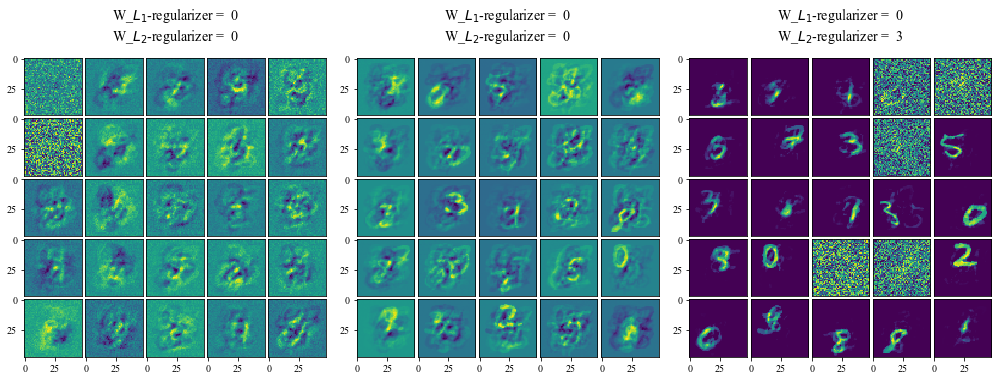

In [40]:
# Simple MNIST binary classification experiments 

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)


idx = np.random.choice(np.arange(X_train.shape[1]), 100)
X0 = X_train[idx,:].T

n_iter = 100
W_list = []
W_sparsity = [[0, 0], [0.5, 0], [0, 3]]

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_$L_{1}$-regularizer = %2.f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %2.f" % W_sparsity[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex2.pdf")

## Dictionary Learing for Face datasets

In [9]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces_centered.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)


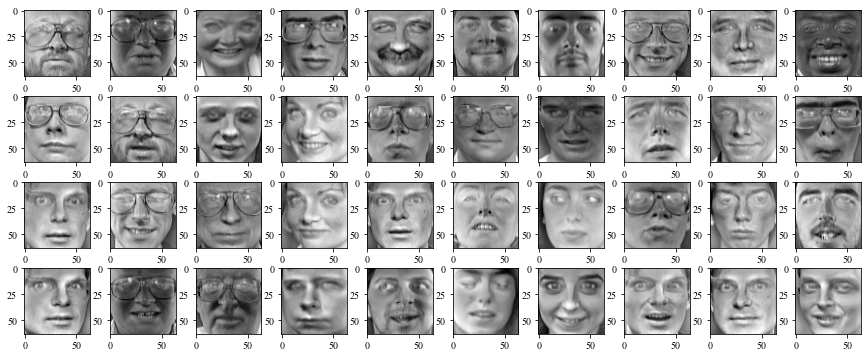

In [10]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        ax[i,j].imshow(faces_centered[i*ncols + j].reshape(64,64), cmap="gray")
        #if i == 0:
        #    ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('Faces_ex1.pdf', bbox_inches='tight')

In [15]:
# Variable nonnegativity constraints 

X0 = faces_centered.T
#X0 /= 100 * np.linalg.norm(X0)

n_iter = 200
W_list = []

# nonnegativitiy = [[False, False], [False, True], [True, True]]
nonnegativitiy = [[True, True]]
n_plots = len(nonnegativitiy)
for i in np.arange(n_plots): 
    W, H = ALS(X=X0, 
               n_components=2, # r
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(n_plots):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)

  2%|██                                                                                | 5/200 [00:00<00:10, 18.94it/s]

iteration 0, reconstruction error 24815.460859


  7%|█████▋                                                                           | 14/200 [00:00<00:10, 18.30it/s]

iteration 10, reconstruction error 22316.397181


 12%|█████████▋                                                                       | 24/200 [00:01<00:10, 17.55it/s]

iteration 20, reconstruction error 22306.915988


 16%|█████████████▎                                                                   | 33/200 [00:01<00:09, 18.41it/s]

iteration 30, reconstruction error 22306.900178


 22%|█████████████████▍                                                               | 43/200 [00:02<00:08, 17.91it/s]

iteration 40, reconstruction error 22306.900139


 26%|█████████████████████▍                                                           | 53/200 [00:02<00:08, 17.54it/s]

iteration 50, reconstruction error 22306.900138


 32%|█████████████████████████▉                                                       | 64/200 [00:03<00:07, 19.12it/s]

iteration 60, reconstruction error 22306.900138


 37%|█████████████████████████████▉                                                   | 74/200 [00:04<00:06, 18.66it/s]

iteration 70, reconstruction error 22306.900138


 42%|██████████████████████████████████▍                                              | 85/200 [00:04<00:05, 19.35it/s]

iteration 80, reconstruction error 22306.900138


 46%|█████████████████████████████████████▋                                           | 93/200 [00:05<00:05, 18.61it/s]

iteration 90, reconstruction error 22306.900138


 52%|██████████████████████████████████████████                                      | 105/200 [00:05<00:04, 19.51it/s]

iteration 100, reconstruction error 22306.900138


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:06<00:04, 17.54it/s]

iteration 110, reconstruction error 22306.900138


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:06<00:04, 17.87it/s]

iteration 120, reconstruction error 22306.900138


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:07<00:03, 17.58it/s]

iteration 130, reconstruction error 22306.900138


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:07<00:02, 19.00it/s]

iteration 140, reconstruction error 22306.900138


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:08<00:02, 18.34it/s]

iteration 150, reconstruction error 22306.900138


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:08<00:01, 20.00it/s]

iteration 160, reconstruction error 22306.900138


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [00:09<00:01, 19.23it/s]

iteration 170, reconstruction error 22306.900138


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:09<00:00, 19.88it/s]

iteration 180, reconstruction error 22306.900138


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [00:10<00:00, 19.58it/s]

iteration 190, reconstruction error 22306.900138


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.62it/s]


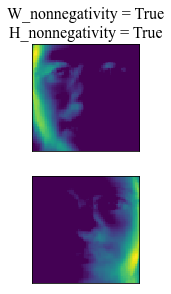

In [16]:
 display_dictionary(W=W_list[0], label=label_list[0], rows=2, cols=1, save_name = "Face_NMF_ex1.pdf")

In [177]:
# Variable regularizer for W

X0 = faces_centered.T
print('X0.shape', X0.shape)

n_iter = 200
W_list = []

# W_sparsity = [[0, 0], [0.5, 0], [0, 3]]
W_sparsity = [[0, 3]]
n_plots = len(W_sparsity)
for i in np.arange(n_plots): 
    W, H = ALS(X=X0,
               n_components=49, # r
               n_iter=n_iter,
               subsample_ratio=1,
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)

# display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex2.pdf")

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

X0.shape (4096, 400)


  0%|▍                                                                                 | 1/200 [00:04<15:21,  4.63s/it]

iteration 0, reconstruction error 24822.127483


  6%|████▍                                                                            | 11/200 [00:54<15:52,  5.04s/it]

iteration 10, reconstruction error 18257.012877


 10%|████████▌                                                                        | 21/200 [01:45<15:11,  5.09s/it]

iteration 20, reconstruction error 17642.100265


 16%|████████████▌                                                                    | 31/200 [02:36<14:04,  5.00s/it]

iteration 30, reconstruction error 17382.316092


 20%|████████████████▌                                                                | 41/200 [03:26<13:15,  5.00s/it]

iteration 40, reconstruction error 17236.328896


 26%|████████████████████▋                                                            | 51/200 [04:34<20:19,  8.18s/it]

iteration 50, reconstruction error 17153.975566


 30%|████████████████████████▋                                                        | 61/200 [06:05<20:34,  8.88s/it]

iteration 60, reconstruction error 17101.128376


 36%|████████████████████████████▊                                                    | 71/200 [07:40<20:54,  9.72s/it]

iteration 70, reconstruction error 17064.825169


 40%|████████████████████████████████▊                                                | 81/200 [09:10<17:57,  9.06s/it]

iteration 80, reconstruction error 17037.889642


 46%|████████████████████████████████████▊                                            | 91/200 [10:39<16:50,  9.27s/it]

iteration 90, reconstruction error 17016.561957


 50%|████████████████████████████████████████▍                                       | 101/200 [12:08<14:40,  8.90s/it]

iteration 100, reconstruction error 16999.104726


 56%|████████████████████████████████████████████▍                                   | 111/200 [13:41<13:48,  9.31s/it]

iteration 110, reconstruction error 16984.298969


 60%|████████████████████████████████████████████████▍                               | 121/200 [15:12<11:52,  9.02s/it]

iteration 120, reconstruction error 16971.533983


 66%|████████████████████████████████████████████████████▍                           | 131/200 [16:44<10:37,  9.23s/it]

iteration 130, reconstruction error 16960.345839


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [18:18<09:29,  9.66s/it]

iteration 140, reconstruction error 16950.601213


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [19:48<07:24,  9.07s/it]

iteration 150, reconstruction error 16941.926737


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [21:20<05:58,  9.20s/it]

iteration 160, reconstruction error 16934.117803


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [22:49<04:16,  8.85s/it]

iteration 170, reconstruction error 16927.239336


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [24:20<02:57,  9.33s/it]

iteration 180, reconstruction error 16920.998037


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [25:55<01:26,  9.62s/it]

iteration 190, reconstruction error 16915.344199


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [27:21<00:00,  8.21s/it]


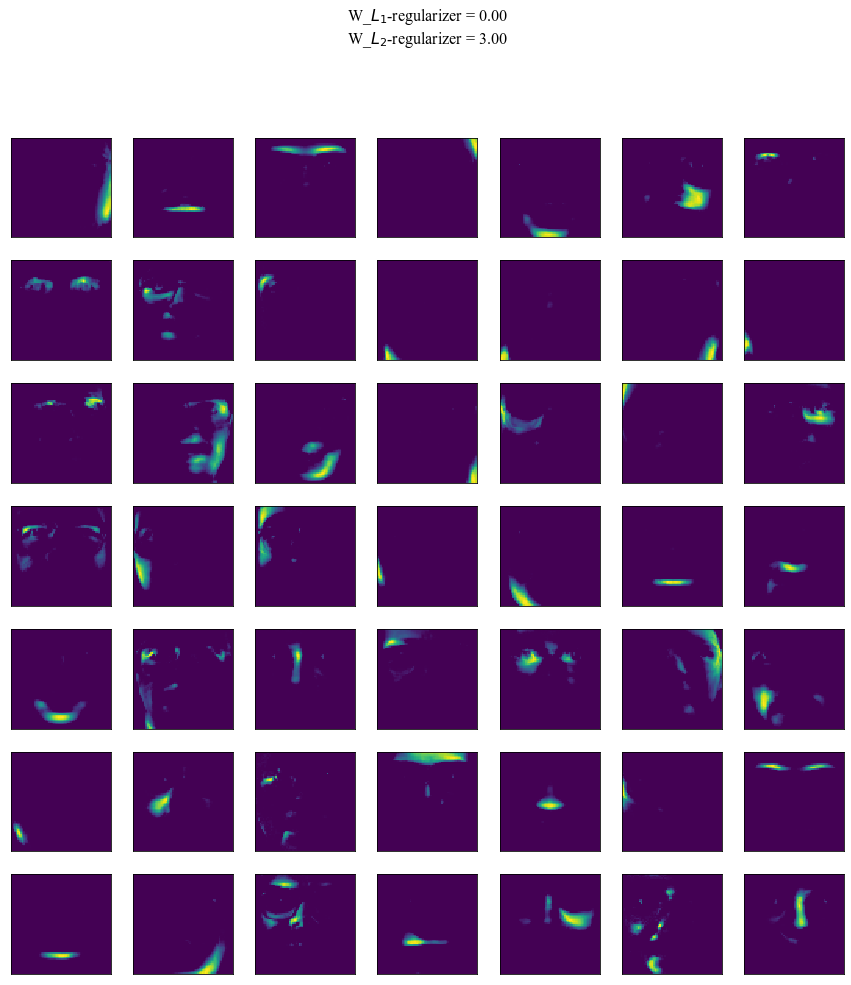

In [178]:
 display_dictionary(W=W_list[0], label=label_list[0], rows=7, cols=7, save_name = "Face_NMF_ex2.pdf")

## Topic modeling for 20Newsgroups dataset

In [ ]:
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import entropy
import pandas as pd

In [ ]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_labels = newsgroups_train.target
# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

# print 10 random documents
#for i in np.arange(10):
#    idx = np.random.choice(len(data_cleaned))
#    print('>>>> %i th doc \n\n %s \n\n' % (idx, data_cleaned[idx]))
    
print('len(newsgroups_labels)', len(newsgroups_labels))
print('newsgroups_labels', newsgroups_labels)

print('data_cleaned[1]', data_cleaned[1])
print('newsgroups_labels[1]', newsgroups_labels[1])

In [ ]:
# vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectorizer_BOW = CountVectorizer(stop_words=stopwords_list)
vectors_BOW = vectorizer_BOW.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
idx_to_word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

print('>>>> vectors.shape', vectors.shape)
i = 4257
print('newsgroups_labels[i]', newsgroups_labels[i])
print('>>>> data_cleaned[i]', data_cleaned[i])
# print('>>>> vectors[:,i] \n', vectors[:,i])


a = vectors[:,i].todense() 
I = np.where(a>0)

count_list = []
word_list = []

for j in np.arange(len(I[0])):
    # idx = np.random.choice(I[0])
    idx = I[0][j]
    # print('>>>> %i th coordinate <===> %s, count %i' % (idx, idx_to_word[idx], vectors[idx, i]))
    count_list.append([idx, vectors_BOW[idx, i], vectors[idx, i]])
    word_list.append(idx_to_word[idx])

d = pd.DataFrame(data=np.asarray(count_list).T, columns=word_list).T
d.columns = ['Coordinate', 'Bag-of-words', 'tf-idf']
cols = ['Coordinate', 'Bag-of-words']
d[cols] = d[cols].applymap(np.int64)

print(d)

In [ ]:
def sample_multiclass_20NEWS(list_classes=[0, 1], full_data=None, vectorizer = 'tf-idf', verbose=True):
    # get train and test set from 20NewsGroups of given categories
    # vectorizer \in ['tf-idf', 'bag-of-words']
    # documents are loaded up from the following 10 categories
    categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'sci.med',
     'sci.space',
     'talk.politics.guns',
     'talk.politics.mideast',
     'talk.religion.misc'
     ]
    
    data_dict = {}
    data_dict.update({'categories': categories})
    
    if full_data is None:
        remove = ('headers','footers','quotes')
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])  
        
        newsgroups_train_full = fetch_20newsgroups(subset='train', categories=categories, remove=remove) # raw documents
        newsgroups_train = [re.sub(r'\d+','', file) for file in newsgroups_train_full.data] # remove numbers (we are only interested in words)
        y = newsgroups_train_full.target # document class labels 
        Y = list2onehot(y.tolist(), list_classes)
       
        
        if vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words=stopwords_list) 
        else:
            vectorizer = CountVectorizer(stop_words=stopwords_list) 
            
        X = vectorizer.fit_transform(newsgroups_train) # words x docs  # in the form of sparse matrix
        X = np.asarray(X.todense())
        print('!! X.shape', X.shape)
        idx2word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

        data_dict.update({'newsgroups_train': data_cleaned})
        data_dict.update({'newsgroups_labels': y})
        data_dict.update({'feature_matrix': vectors})
        data_dict.update({'idx2word': idx2word})
        
    else:
        X, y = full_data

    idx = [i for i in np.arange(len(y)) if y[i] in list_classes] # list of indices where the label y is in list_classes

    X01 = X[idx,:]
    Y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(Y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(Y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

# test 
X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=[0, 1, 2], 
                                                                       vectorizer = 'bag-of-words',
                                                                       full_data=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)
print('y_list', onehot2list(y_test))